In [381]:
import bisect
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.backend.event_processing import event_multiplexer

In [520]:
def cut_off_data(data, steps):
    min_length = min(len(arr) for arr in data.values())
    for key, val in data.items():
        data[key] = val[:min_length]
    steps = steps[:min_length]
    return data, steps

def aggregate_data(data, steps, settings, dataframe=True):
    if dataframe:
        data = pd.DataFrame(data)
        data = data.rename(columns=lambda x: re.sub('NonzeroRewards', 'SuccessRate', x), level=2)
        data.index = steps
    out = []
    for name, df in data.groupby(level=[1, 2], axis=1):
        result = df.apply(pd.DataFrame.describe, axis=1)
        out.append(pd.concat({name: result}, axis=1))
    agg_data = pd.concat(out, axis=1)
    num_runs = len(data.columns.get_level_values(0).unique())
    agg_data = agg_data.reindex(settings, level=0, axis=1)
    return agg_data, num_runs

def plt_agg_data(data, num_runs, prefix=''):
    for name, df in data.groupby(level=[0, 1], axis=1):
        if 'SuccessRate' in name[1]:
            mean = df.xs('mean', level=2, axis=1).squeeze()
            std_err = df.xs('std', level=2, axis=1).squeeze() / math.sqrt(num_runs)
            plt.plot(df.index, mean, label=prefix + name[0], linewidth=3)
            plt.fill_between(df.index, mean - (1.645 * std_err), mean + (1.645 * std_err), alpha=0.35)
            
def get_results(data, num_runs):
    max_success_rate = data.xs('SuccessRateAverage', level=1, axis=1)\
                           .xs('mean', level=1, axis=1).idxmax()
    for g in data.columns.levels[0]:
        data.loc[data[g].index != max_success_rate[g], data.columns.get_level_values(0) == g] = 0
    results = data.max().to_frame().unstack(0)
    results.columns = results.columns.droplevel()
    results = results.T
    for col in results.columns:
        if 'std' == col[1]:
            results[(col[0], 'std error')] = results[col] / math.sqrt(num_runs)
    results = results.sort_index(axis=1)
    results = results.round(2)
    results = results.T
    return results

def print_results(results):
    return results[results.index.get_level_values(1).isin(['mean', 'std error'])]

## VizDoom Fixed Spawn

In [479]:
vizdoom_fixed_spawn_em = event_multiplexer.EventMultiplexer(size_guidance={
                                         event_accumulator.HISTOGRAMS: 1,
                                         event_accumulator.IMAGES: 1,
                                         event_accumulator.SCALARS: 1000
                                         })

In [480]:
vizdoom_fixed_spawn_em.AddRun('../data/local/20200925/vizdoom/run_6/', name='sf-6')
vizdoom_fixed_spawn_em.AddRun('../data/local/20200925/vizdoom/run_7/', name='sf-7')
vizdoom_fixed_spawn_em.AddRun('../data/local/20201001/vizdoom/run_9/', name='sf-9')
vizdoom_fixed_spawn_em.AddRun('../data/local/20201002/vizdoom/run_10', name='sf-10')
vizdoom_fixed_spawn_em.AddRun('../data/local/20201002/vizdoom/run_11', name='sf-11')

vizdoom_fixed_spawn_em.Reload()

In [521]:
settings = ['easy', 'medium', 'hard', 'hardest']
sf_tags = ['LengthAverage', 'NonzeroRewardsAverage']
mapping_tags = ['-length', '-success-rate']
tag_conversions = {'-length': 'LengthAverage', 
                   '-success-rate': 'NonzeroRewardsAverage'}

In [522]:
num_trials = 20
data = {}
for run in vizdoom_fixed_spawn_em.Runs():
    if 'mapping' in run:
        tags = mapping_tags
    else:
        tags = sf_tags
    for setting in settings:
        for tag in tags:
            scalar_name = setting + tag
            if 'mapping' in run:
                scalar_name = 'data/' + scalar_name
                tag = tag_conversions[tag]
            scalars = vizdoom_fixed_spawn_em.Scalars(run, scalar_name)
            data[(run, setting, tag)] = [scalar.value for scalar in scalars]
steps = [scalar.step * 8 for scalar in scalars]

min_length = min(len(arr) for arr in data.values())
for key, val in data.items():
    data[key] = val[:min_length]
steps = steps[:min_length]

In [523]:
agg_data, num_runs = aggregate_data(data, steps, settings)

Text(0.5, 1.0, 'Success Rate for Fixed Spawn')

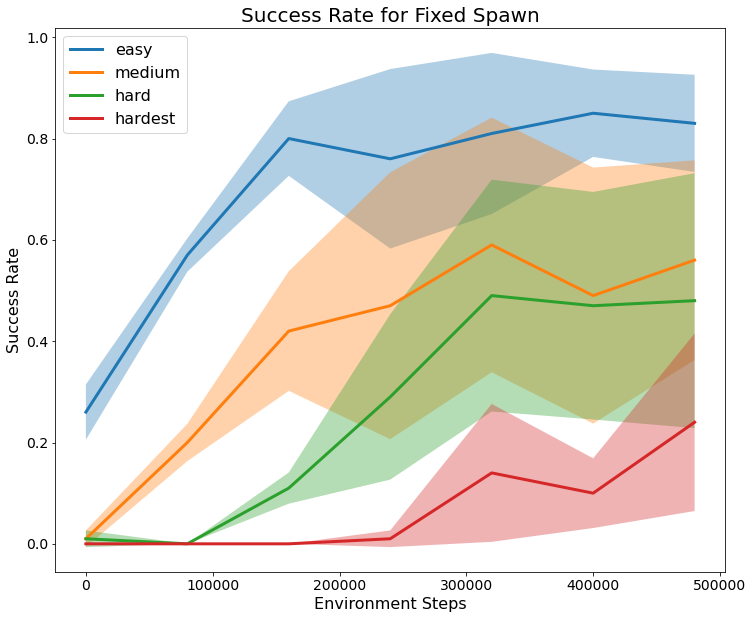

In [524]:
plt.figure(figsize=(12, 10))

plt_agg_data(agg_data, num_runs, '')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Environment Steps', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.legend(fontsize=16)
plt.title('Success Rate for Fixed Spawn', fontsize=20)

In [526]:
fixed_results = get_results(agg_data, num_runs)
print('SF')
print_results(fixed_results)

SF


easy  medium    hard  hardest
LengthAverage      mean       43.53  142.63  223.53   359.13
                   std error   3.83   17.72   21.19    18.04
SuccessRateAverage mean        0.85    0.59    0.49     0.24
                   std error   0.05    0.15    0.14     0.11

## VizDoom: Random Spawn

In [504]:
vizdoom_random_spawn_em = event_multiplexer.EventMultiplexer(size_guidance={
                                         event_accumulator.HISTOGRAMS: 1,
                                         event_accumulator.IMAGES: 1,
                                         event_accumulator.SCALARS: 1000
                                         })

In [506]:
vizdoom_random_spawn_em.AddRun('../data/local/20200922/vizdoom/run_0/', name='sf-0')
vizdoom_random_spawn_em.AddRun('../data/local/20200922/vizdoom/run_1/', name='sf-1')
vizdoom_random_spawn_em.AddRun('../data/local/20200922/vizdoom/run_2/', name='sf-2')

vizdoom_random_spawn_em.Reload()

In [527]:
settings = ['easy', 'medium', 'hard']
sf_tags = ['LengthAverage', 'NonzeroRewardsAverage']
mapping_tags = ['-length', '-success-rate']
tag_conversions = {'-length': 'LengthAverage', 
                   '-success-rate': 'NonzeroRewardsAverage'}

In [528]:
num_trials = 20
data = {}
for run in vizdoom_random_spawn_em.Runs():
    if 'mapping' in run:
        tags = mapping_tags
    else:
        tags = sf_tags
    for setting in settings:
        for tag in tags:
            scalar_name = setting + tag
            if 'mapping' in run:
                scalar_name = 'data/' + scalar_name
                tag = tag_conversions[tag]
            scalars = vizdoom_random_spawn_em.Scalars(run, scalar_name)
            data[(run, setting, tag)] = [scalar.value for scalar in scalars]
steps = [scalar.step * 8 for scalar in scalars]

min_length = min(len(arr) for arr in data.values())
for key, val in data.items():
    data[key] = val[:min_length]
steps = steps[:min_length]


In [476]:
with open('tensorboard/vizdoom-random-spawn-data.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [501]:
with open('tensorboard/vizdoom-random-spawn-data.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [529]:
agg_data, num_runs = aggregate_data(data, steps, settings)

Text(0.5, 1.0, 'Success Rate for Random Spawn')

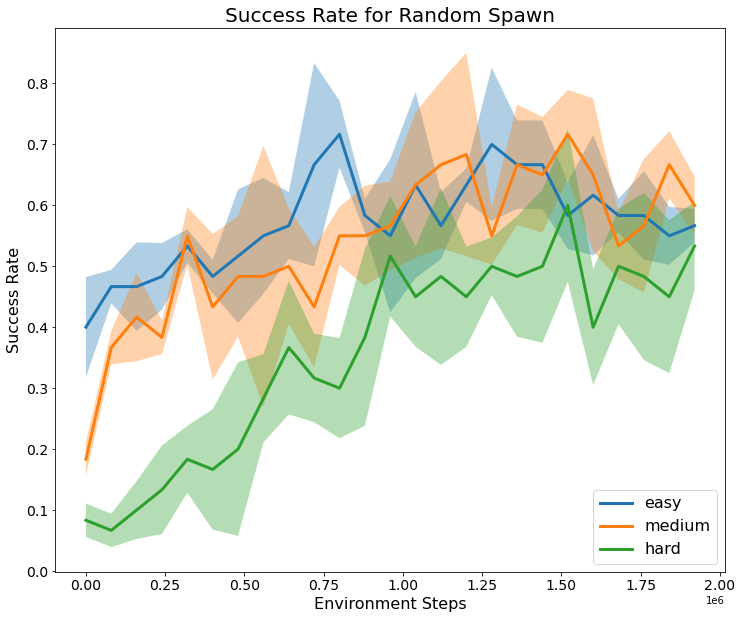

In [530]:
plt.figure(figsize=(12, 10))

plt_agg_data(agg_data, num_runs, '')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Environment Steps', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.legend(fontsize=16, loc='lower right')
plt.title('Success Rate for Random Spawn', fontsize=20)

In [531]:
sf_results = get_results(agg_sf_data, num_runs)
print('SF')
print_results(sf_results)

SF


easy  medium    hard
LengthAverage      mean       50.32  117.83  215.05
                   std error   2.49    3.70   11.92
SuccessRateAverage mean        0.72    0.72    0.60
                   std error   0.03    0.04    0.08

## MiniGrid

In [ ]:
em = event_multiplexer.EventMultiplexer(size_guidance={
                                         event_accumulator.HISTOGRAMS: 1,
                                         event_accumulator.IMAGES: 1,
                                         event_accumulator.SCALARS: 1000
                                         })

In [406]:
em.AddRun('../../mapping/runs/minigrid_6_clipv_-10.0_dist_0.1/', name='mapping-1')
em.AddRun('../../mapping/runs/minigrid_9_clipv_-10.0_dist_0.1/', name='mapping-2')
em.AddRun('../../mapping/runs/minigrid_10_clipv_-10.0_dist_0.1/', name='mapping-3')
em.AddRun('../../mapping/runs/minigrid_15_clipv_-10.0_dist_0.1/', name='mapping-4')
em.AddRun('../../mapping/runs/minigrid_16_clipv_-10.0_dist_0.1/', name='mapping-5')

em.AddRun('../data/local/20200930/minigrid/run_67/', name='sf-1')
em.AddRun('../data/local/20200930/minigrid/run_71/', name='sf-2')
em.AddRun('../data/local/20200930/minigrid/run_72/', name='sf-3')
em.AddRun('../data/local/20200930/minigrid/run_73/', name='sf-4')
em.AddRun('../data/local/20200930/minigrid/run_74/', name='sf-5')

em.Reload()

In [532]:
# Minigrid
settings = ['multiroom']
sf_tags = ['LengthAverage', 'NonzeroRewardsAverage', 'EndDistanceToGoal']
mapping_tags = ['length', 'success-rate', 'end-distance']
tag_conversions = {'length': 'LengthAverage', 
                   'success-rate': 'NonzeroRewardsAverage',
                   'end-distance': 'EndDistanceToGoal'}

num_trials = 10
mapping_data = {}
sf_data = {}
for run in em.Runs():
    if 'mapping' in run:
        tags = mapping_tags
    else:
        tags = sf_tags
    for tag in tags:
        scalar_name = tag
        if 'mapping' in run:
            scalar_name = 'data/' + scalar_name
            tag = tag_conversions[tag]
        scalars = em.Scalars(run, scalar_name)
        
        if 'mapping' in run:
            mapping_data[(run, settings[0], tag)] = [scalar.value for scalar in scalars]
            mapping_steps = [scalar.step * 8 for scalar in scalars]
        else:
            sf_data[(run, settings[0], tag)] = [scalar.value for scalar in scalars]
            sf_steps = [scalar.step for scalar in scalars]


In [ ]:
with open('tensorboard/minigrid-mapping-data.pkl', 'wb') as handle:
    pickle.dump(mapping_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tensorboard/minigrid-sf-data.pkl', 'wb') as handle:
    pickle.dump(sf_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [533]:
mapping_data, mapping_steps = cut_off_data(mapping_data, mapping_steps)
sf_data, sf_steps = cut_off_data(sf_data, sf_steps)

In [534]:
agg_mapping_data, num_runs = aggregate_data(mapping_data, mapping_steps, settings)
agg_sf_data, num_runs = aggregate_data(sf_data, sf_steps, settings)

In [536]:
check = agg_mapping_data.index.tolist()

In [537]:
idx = bisect.bisect_left(check, agg_sf_data.index[-1])

Text(0.5, 1.0, 'Success Rate for MiniGrid')

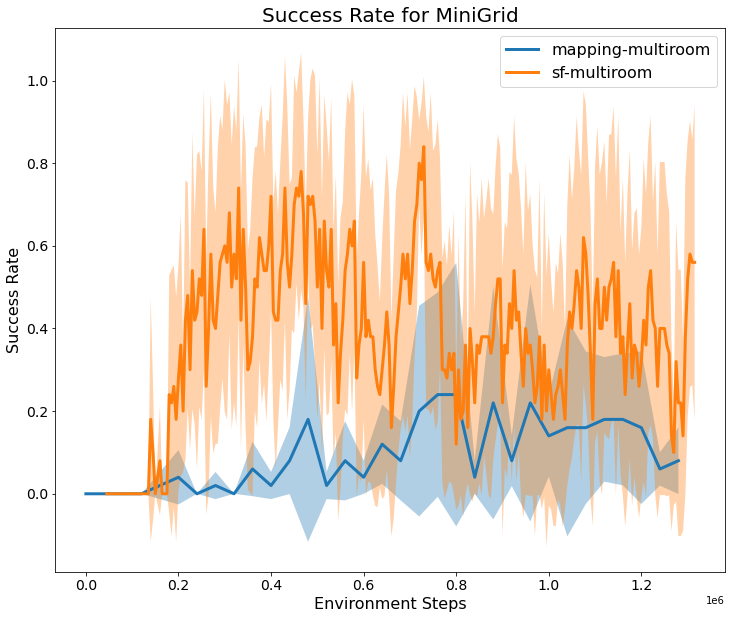

In [538]:
plt.figure(figsize=(12, 10))

plt_agg_data(agg_mapping_data[:idx], num_runs, 'mapping-')
plt_agg_data(agg_sf_data, num_runs, 'sf-')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Environment Steps', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.legend(fontsize=16)
plt.title('Success Rate for MiniGrid', fontsize=20)